In [2]:
from test_fair_clustering import main
import argparse
import os
import csv
import numpy as np
import json
from scipy.stats import norm

In [3]:
OUTPUT_FOLDER = "outputs"
DATA_FOLDER = "data"
CSV_NAME = "results.csv"
CSV_NAME_LIPSCHITZ = "results_Lipschitz.csv"
FINAL_RESULTS_NAME = "final_results.txt"

DEFAULT_RUNS = 30
DEFAULT_REPROD_L = 2.0
MODES = ["reprod", "lmbda_reprod", "Lipz_replic", "additional"]
settings = {
    "Synthetic": {
        "kmedian": {
            "reprod":       {"lmbda": 10,       # got consistently bad results
            },
            "lmbda_reprod": {"lmbda": 600,
            }
        },
        "kmeans": {
            "reprod":       {"lmbda": 10,       # got optimal results only on some seeds
            },
            "lmbda_reprod": {"lmbda": 100,
            }
        },
        "ncut": {
            "reprod":       {"lmbda": 10,       # Successful reprod
                             "Lipschitz": 1.0,
            }
        },
    }, 
    "Synthetic-unequal": {
        "kmedian": {
            "reprod":       {"lmbda": 10        # Successful reprod
            }
        },
        "kmeans": {
            "reprod":       {"lmbda": 10,       # seeds 20,22,24 are outliers. Successful reprod if left out.
            }
        }, 
        "ncut": {
            "reprod":       {"lmbda": 10,       # Successful reprod
                             "Lipschitz": 1.0,
            }
        },
    }, 
    "Adult": {
        "kmedian": {
            "reprod":       {"lmbda": 9000,
            },
            "Lipz_replic":  {"lmbda": 6500,
                             "Lipschitz": 0.5,
            }
        },
        "kmeans": {
            "reprod":       {"lmbda": 9000,
            },
            "Lipz_replic":  {"lmbda": 9500,
                             "Lipschitz": 1.0,
            }
        },
        "ncut": {
            "reprod":       {"lmbda": 10,       # Successful reprod
                             "Lipschitz": 1.0,
                             "runs": 5,
            },
            "Lipz_replic":  {"lmbda": 2,
                             "Lipschitz": 0.00001,
            }
        }
    }, 
    "Bank": {
        "kmedian": {
            "reprod":       {"lmbda": 9000,
            },
            "Lipz_replic":  {"lmbda": 9000,
                             "Lipschitz": 1.0,
            }
        },
        "kmeans": {
            "reprod":       {"lmbda": 6000,
            },
            "Lipz_replic":  {"lmbda": 9500,
                             "Lipschitz": 1.0,
            }
        },
        "ncut": {
            "reprod":       {"lmbda": 40,       # Successful reprod
                             "Lipschitz": 1.0,
                             "runs": 5,
            },
            "Lipz_replic":  {"lmbda": 1.2,
                             "Lipschitz": 0.0001,
            }
        }
    }, 
    "CensusII": {
        "kmedian": {
            "reprod":       {"lmbda": 500000,
                             "runs": 5,
            }
        },
        "kmeans": {
            "reprod":       {"lmbda": 500000,
                             "runs": 5,
            }
        },
        "ncut": {
            "reprod":       {"lmbda": 100,      # Maybe would've worked with lower lambda
                             "Lipschitz": 1.0,
                             "runs": 5,
            },
            "Lipz_replic":  {"lmbda": .5,
                             "Lipschitz": 0.00001,
                             "runs": 1,
            }
        }
    }
}

additional = {
    "Synthetic": {
        "kmedian": [
        ],
        "kmeans": [
        ],
        "ncut": [           {"lmbda": 10,
                             "Lipschitz": 2.0,
            }
        ],
    }, 
    "Synthetic-unequal": {
        "kmedian": [
        ],
        "kmeans": [
        ],
        "ncut": [           {"lmbda": 10,
                             "Lipschitz": 2.0,
            }
        ],
    }, 
    "Adult": {
        "kmedian": [
        ],
        "kmeans": [
        ],
        "ncut": [           {"lmbda": 10
            },
                            {"lmbda": 1.5,
                             "Lipschitz": 0.001,
            }
        ],
    }, 
    "Bank": {
        "kmedian": [
        ],
        "kmeans": [         {"lmbda": 9000,
                             "Lipschitz": 1.0,
            }
        ],
        "ncut": [           {"lmbda": 40,
            },
                            {"lmbda": 1,
                             "Lipschitz": 0.001,
            }
        ],
    }, 
    "CensusII": {
        "kmedian": [
        ],
        "kmeans": [
        ],
        "ncut": [           {"lmbda": 100
            },
                            {"lmbda": 2.5,
                             "Lipschitz": 0.001,
            },
                            {"lmbda": 1,
                             "Lipschitz": 1e-5,
            }
        ],
    }
}

n_runs_Lipschitz = 10
Lipschitz_constants = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0]

In [4]:
def get_args(seed=1, dataset="Synthetic-unequal", cluster_option="ncut", lmbda=None, lmbda_tune=False, Lipschitz=None, plot_bound_update=False):
    """
    Return Namespace instance with passed and default arguments for main().

    plot_bound_update:
        if True, lets main() return a list of energies of a single bound update. Meant for checking convergence.
    """
    args = argparse.Namespace()
    
    args.plot_option_clusters_vs_lambda = False     # Only available for the synthetic datasets
    args.plot_option_fairness_vs_clusterE = True    # Only works when lmbda_tune == True
    args.plot_option_balance_vs_clusterE = False    # Only works when lmbda_tune == True
    args.plot_option_convergence = False
    args.plot_bound_update = plot_bound_update      # Return a list of the energies of a single bound update
    
    args.Bera = False
    args.kernel_type = None
    args.kernel_args = "1_2"

    args.seed = seed
    args.dataset = dataset
    args.cluster_option = cluster_option
    args.lmbda_tune = lmbda_tune

    if lmbda:
        args.lmbda = lmbda
    else:
        args.lmbda = settings[dataset][cluster_option]["reprod"]["lmbda"]
    
    if Lipschitz:
        args.L = Lipschitz
    elif "Lipschitz" in settings[dataset][cluster_option]["reprod"]:
        args.L = settings[dataset][cluster_option]["reprod"]["Lipschitz"]
    else:
        args.L = DEFAULT_REPROD_L

    working_dir = os.getcwd()
    args.data_dir = os.path.join(working_dir, DATA_FOLDER)
    args.output_path = os.path.join(working_dir, OUTPUT_FOLDER)
    return args

def make_csv(dir_path, csv_path, fieldnames):
    """
    Make path and csv file with header if it doesn't exist yet. Otherwise do nothing.

    dir_path:
        full path to directory
    csv_path:
        full path to directory including the csv file
    fieldnames:
        fieldnames for the csv
    """
    os.makedirs(dir_path, exist_ok=True)
    if os.path.isfile(csv_path):
        with open(csv_path, "r") as f:
            reader = csv.reader(f)
            if sum(1 for row in reader) > 0:
                return

    with open(csv_path, "w", newline='') as f:
        writer = csv.DictWriter(f, fieldnames)
        writer.writeheader()

def run_main(args, csv_name=CSV_NAME):
    """
    Run main and append results with settings to csv file.
    File is automatically made if it doesn't exist yet.

    csv_name:
        just the filename of the csv, eg "results.csv"
    """
    results = main(args, logging=False, seedable=True)
    
    save_dict = {
        "dataset": args.dataset,
        "N": results['N'],                                      # Dataset size
        "J": results['J'],                                      # Number of demographic groups (defined in dataset_load.py)
        "lmbda": args.lmbda,
        "Objective": results["clustering energy (Objective)"],  # Discrete clustering energy
        "fairness error": results["fairness error"],
        "balance": results["balance"],
        "cluster_option": args.cluster_option,
        "time": results["time"],                                # Time taken to finish this run
        "seed": args.seed,
        "lmbda_tune": args.lmbda_tune,                          
        "K": results['K'],                                      # Number of clusters (defined in dataset_load.py)
        "L": args.L,                                            # Lipschitz constant
    }

    csv_path = os.path.join(args.output_path, csv_name)
    fieldnames = save_dict.keys()
    make_csv(args.output_path, csv_path, fieldnames)
    with open(csv_path, "a", newline='') as f:
        writer = csv.DictWriter(f, fieldnames)
        writer.writerow(save_dict)
    

In [5]:
def compare_entry(args, entry, keys):
    """
    Compare args to an entry from the csv file and return True if they have the given keys in common:

    args:
        arguments that will be passed to main()
    entry:
        entry in the csv file made by run_main()
    """
    for key in keys:
        if str(getattr(args, key)) != entry[key]:
            return False
    return True

def find_same_options(csv_name, args, keys=["dataset", "lmbda", "cluster_option", "lmbda_tune", "L"]):
    """
    Return entries from the csv file that have the same settings as the passed args, using compare_entry().

    csv_name:
        filename of the csv, eg "results.csv"
    args:
        arguments that will be passed to main()
    """
    entries = []
    csv_path = os.path.join(args.output_path, csv_name)
    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if compare_entry(args, row, keys):
                entries.append(row)
    return entries

def filter_outliers(entries, keys, sensitivity=4):
    outlier_seeds = set()

    N = len(entries)
    T_N = abs(norm.ppf(1/(sensitivity*N)))
    for key in keys:
        sample = [float(entry[key]) for entry in entries]
        mean = np.mean(sample)
        std = np.std(sample)
        for entry in entries:
            distance = abs(float(entry[key]) - mean) / (std + 0.01*mean)
            if distance > T_N:
                outlier_seeds.add(entry["seed"])
    new_entries = []
    for entry in entries:
        if entry["seed"] in outlier_seeds:
            continue
        new_entries.append(entry)
    return new_entries, outlier_seeds

In [6]:
"""Execute one run"""
# run_main(get_args(
#     seed = 3, 
#     dataset = "CensusII",
#     cluster_option = "ncut", 
#     lmbda = .5,
#     # lmbda_tune = True, 
#     Lipschitz = 1e-5,     # Lipschitz constant
# ))

'Execute one run'

In [7]:
"""Run all settings with different seeds"""
for mode in MODES:
    for dataset in settings:
        for cluster_option in settings[dataset]:
            if mode not in settings[dataset][cluster_option]:
                continue

            lmbda = settings[dataset][cluster_option][mode]["lmbda"]
            L = DEFAULT_REPROD_L             
            if "Lipschitz" in settings[dataset][cluster_option][mode]:
                L = settings[dataset][cluster_option][mode]["Lipschitz"]

            args = get_args(dataset=dataset, cluster_option=cluster_option, lmbda=lmbda, Lipschitz=L)
            existing_entries = find_same_options(CSV_NAME, args)

            n_runs = DEFAULT_RUNS
            if "runs" in settings[dataset][cluster_option][mode]:
                n_runs = settings[dataset][cluster_option][mode]["runs"]
                
            if len(existing_entries) >= n_runs:
                print("enough results for these settings")
                continue
            n_todo = n_runs - len(existing_entries)

            seeds = [int(entry["seed"]) for entry in existing_entries]
            seeds.append(0) # Make sure seeds is not empty
            next_seed = max(seeds) + 1

            for new_seed in range(next_seed, next_seed + n_todo):
                args.seed = new_seed
                print()
                run_main(args, CSV_NAME)

enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings
enough results for these settings


In [8]:
"""Fetch results from the csv"""
def print_M_and_SD(entries, keys=["Objective", "fairness error", "balance", "time"], printing=True):
    results = {}
    for key in keys:
        sample = [float(entry[key]) for entry in entries]
        mean = np.mean(sample)
        std = np.std(sample)

        mean_str = f"M = {mean:.3f}"
        std_str = f"SD = {std:.3f}"
        if printing:
            print(f"      {key}{' '*(20-len(key))}{mean_str}{' '*(20-len(mean_str))}{std_str}{' '*(15-len(std_str))}({std/mean*100:.1f}%)")

        results[key] = {"mean": mean, "std": std}
    return results

def print_results(entries):
    entry = entries[0]
    print(f"    lmbda={entry['lmbda']}, Lipschitz={entry['L']}, runs={len(entries)}")
    
    print_M_and_SD(entries)

    filtered_entries, seeds = filter_outliers(entries, ["Objective", "fairness error", "balance"])
    printing = len(seeds) > 0
    if printing:
        print(f"\n      without {len(seeds)} outliers: {seeds}")
    return print_M_and_SD(filtered_entries, printing=printing)

final_results = {}
experiments_runtime = 0
census_runtime = 0
for mode in MODES:
    final_results[mode] = {}
    print(f"\n\n{mode.upper()}")
    for dataset in settings:
        print(f"\n  {dataset}")
        for cluster_option in settings[dataset]:
            if mode not in settings[dataset][cluster_option]:
                continue

            print("\n    "+cluster_option.upper())

            lmbda = settings[dataset][cluster_option][mode]["lmbda"]
            L = DEFAULT_REPROD_L
            if "Lipschitz" in settings[dataset][cluster_option][mode]:
                L = settings[dataset][cluster_option][mode]["Lipschitz"]

            args = get_args(dataset=dataset, cluster_option=cluster_option, lmbda=lmbda, Lipschitz=L)
            existing_entries = find_same_options(CSV_NAME, args)
            
            if len(existing_entries) < 1:
                print("no data yet")
                continue

            runtime = sum([float(entry["time"]) for entry in existing_entries])
            experiments_runtime += runtime
            if dataset == "CensusII":
                census_runtime += runtime
            results = print_results(existing_entries)

            if cluster_option not in final_results[mode]:
                final_results[mode][cluster_option] = {}
            final_results[mode][cluster_option][dataset] = results
with open(os.path.join(OUTPUT_FOLDER, FINAL_RESULTS_NAME), "w") as f:
    f.write(json.dumps(final_results))

additional_runtime = 0
print(f"\n\n{'additional'.upper()}")
for dataset in settings:
    print(f"\n  {dataset}")
    for cluster_option in settings[dataset]:
        configs = additional[dataset][cluster_option]
        if len(configs) < 1:
            continue

        print("\n    "+cluster_option.upper())
        for config in configs:
            lmbda = config["lmbda"]
            L = DEFAULT_REPROD_L
            if "Lipschitz" in config:
                L = config["Lipschitz"]

            args = get_args(dataset=dataset, cluster_option=cluster_option, lmbda=lmbda, Lipschitz=L)
            existing_entries = find_same_options(CSV_NAME, args)
            
            if len(existing_entries) < 1:
                print("no data yet")
                continue

            runtime = sum([float(entry["time"]) for entry in existing_entries])
            additional_runtime += runtime
            if dataset == "CensusII":
                census_runtime += runtime            
            print_results(existing_entries)

print(f"Experiments runtime:    {experiments_runtime:.1f}    ({experiments_runtime/3600:.2f} Hours)")
print(f"Census II runtime:      {census_runtime:.1f}    ({census_runtime/3600:.2f} Hours)")
total_runtime = experiments_runtime + additional_runtime
print(f"Total runtime:          {total_runtime:.1f}    ({total_runtime/3600:.2f} Hours)")



REPROD

  Synthetic

    KMEDIAN
    lmbda=10, Lipschitz=2.0, runs=30
      Objective           M = 289.079         SD = 2.033     (0.7%)
      fairness error      M = 0.820           SD = 1.053     (128.5%)
      balance             M = 0.338           SD = 0.205     (60.6%)
      time                M = 4.783           SD = 1.654     (34.6%)

    KMEANS
    lmbda=10, Lipschitz=2.0, runs=30
      Objective           M = 203.663         SD = 2.553     (1.3%)
      fairness error      M = 2.428           SD = 1.468     (60.5%)
      balance             M = 0.274           SD = 0.438     (159.8%)
      time                M = 4.590           SD = 2.285     (49.8%)

    NCUT
    lmbda=10, Lipschitz=1.0, runs=30
      Objective           M = 0.198           SD = 0.100     (50.6%)
      fairness error      M = 0.000           SD = 0.000     (nan%)
      balance             M = 0.979           SD = 0.017     (1.7%)
      time                M = 5.767           SD = 1.937     (33.6%)

  Syn

In [9]:
for dataset in ["Adult", "Bank"]:
    for cluster_option in ["kmeans", "ncut"]:
        L_list = [2.0]
        if cluster_option == "ncut":
            L_list = [0.001, 2.0]
        for L in L_list:
            name = f'Fair_{cluster_option}_fairness_vs_clusterEdiscrete_Lip{L}_{dataset}'
            savefile = os.path.join("outputs", dataset, name+'.npz')
            if os.path.exists(savefile):
                print("Result already present")
                continue
            
            run_main(get_args(1, dataset, cluster_option, lmbda_tune=True, Lipschitz=L))

Result already present
Result already present
Result already present
Result already present
Result already present
Result already present


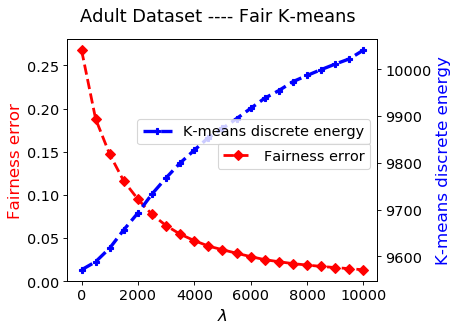

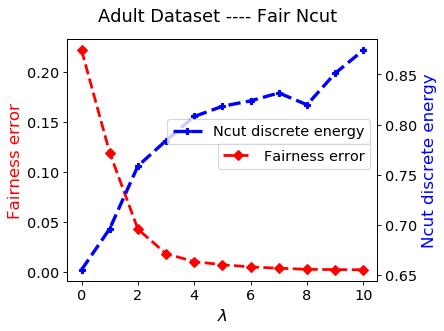

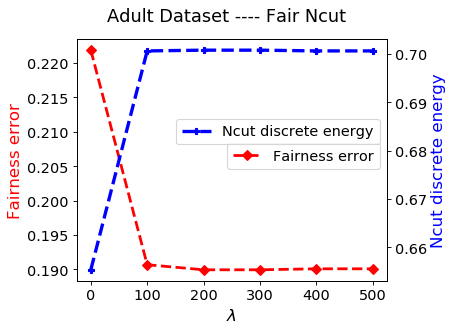

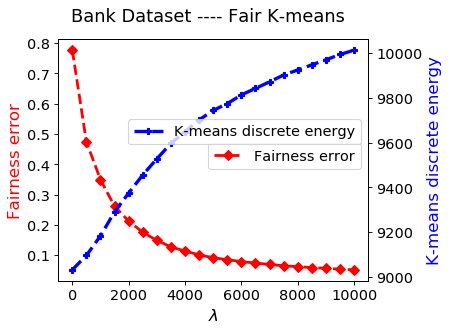

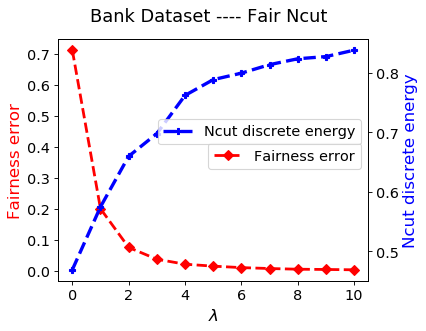

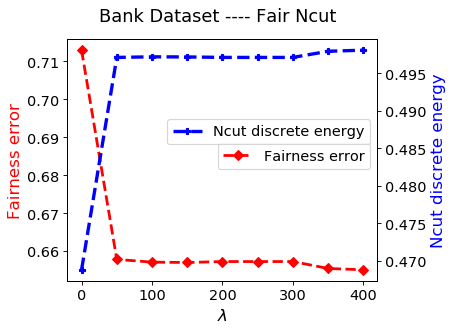

In [10]:
from data_visualization import plot_fairness_vs_clusterE
%matplotlib inline

for dataset in ["Adult", "Bank"]:
    for cluster_option in ["kmeans", "ncut"]:
        L_list = [2.0]
        if cluster_option == "ncut":
            L_list = [0.001, 2.0]
        for L in L_list:
            name = f'Fair_{cluster_option}_fairness_vs_clusterEdiscrete_Lip{L}_{dataset}'
            savefile = os.path.join("outputs", dataset, name+'.npz')
            filename = os.path.join("outputs", dataset, name+'.png')

            if not os.path.exists(savefile):
                print("Results missing")
                continue
            plot_fairness_vs_clusterE(cluster_option, savefile, filename, None, None, None, None, None, save=False, save_without_title=True)

In [11]:
def run_Lipschitz_test(args, csv_name=CSV_NAME_LIPSCHITZ):
    """
    Run bound update and append results with settings to csv file.
    File is automatically made if it doesn't exist yet.
    Logs of energy values by iteration are saved to .txt files as json, the path to which is saved in a csv field.

    csv_name:
        just the filename of the csv, eg "results_Lipschitz.csv"
    """
    args.plot_bound_update = True
    bound_energy_list, elapsed = main(args, logging=False, seedable=True)

    list_dir = os.path.join(args.dataset, "Lipschitz_energy_list_logs")
    os.makedirs(os.path.join(args.output_path, list_dir), exist_ok=True)
    list_filepath = os.path.join(list_dir, f"{args.cluster_option}__L={args.L}__lmb={args.lmbda}__seed={args.seed}.txt")
    list_filepath_full = os.path.join(args.output_path, list_filepath)
    with open(list_filepath_full, "w") as f:
        f.write(json.dumps(bound_energy_list))

    save_dict = {
        "dataset": args.dataset,
        "lmbda": args.lmbda,
        "cluster_option": args.cluster_option,
        "L": args.L,                            # Lipschitz constant
        "convergence_iter": len(bound_energy_list),
        "optimum": min(bound_energy_list),
        "time": elapsed,                        # Time taken to finish this run
        "seed": args.seed,
        "energy_list_file": list_filepath,        
    }

    csv_path = os.path.join(args.output_path, csv_name)
    fieldnames = save_dict.keys()
    make_csv(args.output_path, csv_path, fieldnames)
    with open(csv_path, "a", newline='') as f:
        writer = csv.DictWriter(f, fieldnames)
        writer.writerow(save_dict)

In [12]:
# run_Lipschitz_test(get_args(Lipschitz=0.0001, plot_bound_update=True))

In [ ]:
"""Run Lipschitz test for multiple settings"""

for dataset in ["Synthetic", "Synthetic-unequal", "Adult", "Bank"]:
    for cluster_option in ["kmedian", "kmeans", "ncut"]:
        for L in Lipschitz_constants:

            args = get_args(dataset=dataset, cluster_option=cluster_option, lmbda=1, Lipschitz=L, plot_bound_update=True)
            existing_entries = find_same_options(CSV_NAME_LIPSCHITZ, args, keys=["dataset", "cluster_option", "L"])

            if len(existing_entries) >= n_runs_Lipschitz:
                print("enough results for these settings")
                continue
            n_todo = n_runs_Lipschitz - len(existing_entries)

            seeds = [int(entry["seed"]) for entry in existing_entries]
            seeds.append(0) # Make sure seeds is not empty
            next_seed = max(seeds) + 1

            for new_seed in range(next_seed, next_seed + n_todo):
                args.seed = new_seed
                print()
                run_Lipschitz_test(args, CSV_NAME_LIPSCHITZ)

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_Lipschitz_convergence(save_path, energy_list_by_L, yscale_log=False):
    """Plot clustering objective by iteration for different Lipschitz constants"""
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    for L, lis in energy_list_by_L.items():
        ax.plot(range(len(lis["mean"])), lis["mean"], label=f"L = {L}")
        # plt.fill_between(range(len(lis["std"])), lis["mean"]+lis["std"], lis["mean"]-lis["std"], alpha=.5)
    ax.legend()
    ax.set_ylabel("fair objective")
    ax.set_xlabel("iterations")
    suffix = ""
    margin = 0.05
    if yscale_log:
        max_val = np.max([max(lis["mean"][1:]) for lis in energy_list_by_L.values()])
        min_val = min(energy_list_by_L[0.01]["mean"])
        y_range = max_val - min_val
        ax.set_ylim(min_val-y_range*margin, max_val+y_range*margin)
        ax.set_yscale('log')
        suffix = "_y-log"
    else:
        max_val = max(energy_list_by_L[0.01]["mean"][1:])
        min_val = min(energy_list_by_L[0.01]["mean"])
        y_range = max_val - min_val
        ax.set_ylim(min_val-y_range*margin, max_val+y_range*margin)
    x_range = max([len(lis["mean"]) for lis in energy_list_by_L.values()])
    if x_range > 100:
        ax.set_xscale('log')
    plt.savefig(save_path.format(suffix=suffix))
    plt.show()
    plt.close('all')

def plot_Lipschitz_conv_iter(save_path, conv_iter_by_L):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    for L, conv_iter in conv_iter_by_L.items():
        ax.bar(str(L), conv_iter["mean"], color="darkred")
    ax.set_ylabel("iterations to convergence in bound update")
    ax.set_xlabel("Lipschitz constant")
    if max([conv_iter["mean"] for conv_iter in conv_iter_by_L.values()]) > 500:
        ax.set_yscale('log')
    plt.savefig(save_path.format(suffix=""))
    plt.show()
    plt.close('all')



Adult

  KMEDIAN

    Lipschitz = 1e-05
    convergence_iter     M = 9.00     SD = 2.28
    optimum              M = 19413.67     SD = 349.19
    time                 M = 0.80     SD = 0.14

    Lipschitz = 0.0001
    convergence_iter     M = 6.70     SD = 1.55
    optimum              M = 19414.50     SD = 348.75
    time                 M = 0.69     SD = 0.07

    Lipschitz = 0.001
    convergence_iter     M = 7.20     SD = 0.40
    optimum              M = 19413.88     SD = 349.16
    time                 M = 0.45     SD = 0.02

    Lipschitz = 0.01
    convergence_iter     M = 11.20     SD = 0.40
    optimum              M = 19414.18     SD = 349.18
    time                 M = 0.60     SD = 0.02

    Lipschitz = 0.1
    convergence_iter     M = 23.30     SD = 0.46
    optimum              M = 19415.32     SD = 349.17
    time                 M = 1.14     SD = 0.04

    Lipschitz = 1.0
    convergence_iter     M = 87.40     SD = 1.62
    optimum              M = 19421.84     SD =

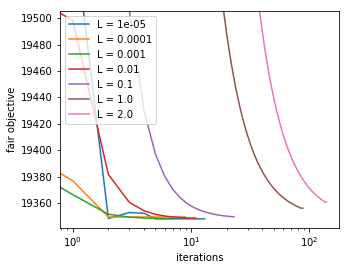

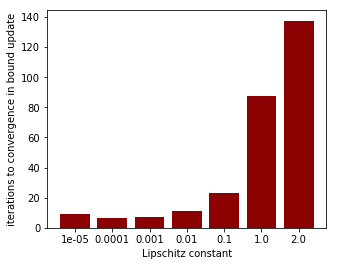


  KMEANS

    Lipschitz = 1e-05
    convergence_iter     M = 7.50     SD = 2.29
    optimum              M = 13160.41     SD = 395.82
    time                 M = 0.68     SD = 0.10

    Lipschitz = 0.0001
    convergence_iter     M = 6.30     SD = 1.55
    optimum              M = 13160.70     SD = 395.79
    time                 M = 0.50     SD = 0.13

    Lipschitz = 0.001
    convergence_iter     M = 7.00     SD = 0.45
    optimum              M = 13160.56     SD = 395.83
    time                 M = 0.46     SD = 0.02

    Lipschitz = 0.01
    convergence_iter     M = 11.10     SD = 0.30
    optimum              M = 13160.75     SD = 395.83
    time                 M = 0.61     SD = 0.01

    Lipschitz = 0.1
    convergence_iter     M = 22.80     SD = 0.60
    optimum              M = 13161.50     SD = 395.83
    time                 M = 1.13     SD = 0.03

    Lipschitz = 1.0
    convergence_iter     M = 84.70     SD = 1.90
    optimum              M = 13165.84     SD = 395.91
 

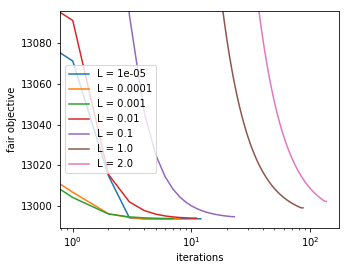

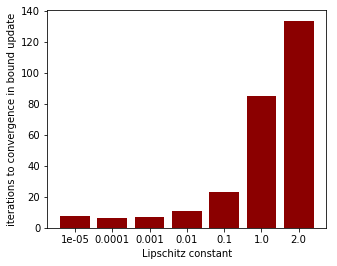


  NCUT

    Lipschitz = 1e-05
    convergence_iter     M = 5.00     SD = 0.00
    optimum              M = -151484318815400787968.00     SD = 58166935139713949696.00
    time                 M = 0.60     SD = 0.04

    Lipschitz = 0.0001
    convergence_iter     M = 5.20     SD = 0.40
    optimum              M = -36742717812634746880.00     SD = 56201459583273877504.00
    time                 M = 0.40     SD = 0.03

    Lipschitz = 0.001
    convergence_iter     M = 171.40     SD = 81.17
    optimum              M = -6.93     SD = 3.47
    time                 M = 6.03     SD = 2.75

    Lipschitz = 0.01
    convergence_iter     M = 501.60     SD = 10.97
    optimum              M = -8.66     SD = 0.06
    time                 M = 17.42     SD = 0.57

    Lipschitz = 0.1
    convergence_iter     M = 2210.70     SD = 70.33
    optimum              M = -8.97     SD = 0.19
    time                 M = 80.11     SD = 0.62

    Lipschitz = 1.0
    convergence_iter     M = 10000.00     SD

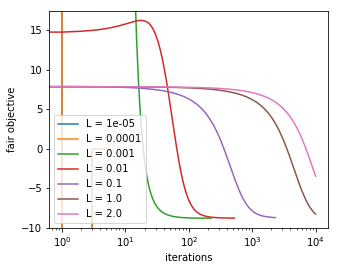

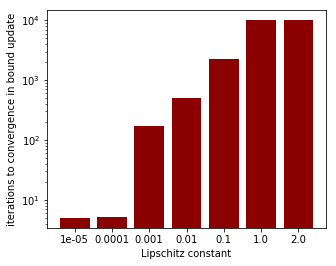



Bank

  KMEDIAN

    Lipschitz = 1e-05
    convergence_iter     M = 5.00     SD = 0.89
    optimum              M = 21859.41     SD = 524.79
    time                 M = 0.96     SD = 0.12

    Lipschitz = 0.0001
    convergence_iter     M = 5.10     SD = 0.54
    optimum              M = 21859.49     SD = 524.81
    time                 M = 0.81     SD = 0.05

    Lipschitz = 0.001
    convergence_iter     M = 7.10     SD = 0.30
    optimum              M = 21859.64     SD = 524.80
    time                 M = 1.02     SD = 0.11

    Lipschitz = 0.01
    convergence_iter     M = 11.70     SD = 0.46
    optimum              M = 21859.99     SD = 524.84
    time                 M = 1.24     SD = 0.07

    Lipschitz = 0.1
    convergence_iter     M = 24.00     SD = 0.63
    optimum              M = 21861.36     SD = 524.79
    time                 M = 1.98     SD = 0.07

    Lipschitz = 1.0
    convergence_iter     M = 91.30     SD = 3.32
    optimum              M = 21869.01     SD = 

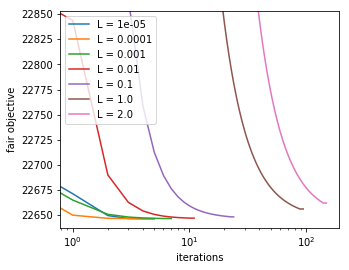

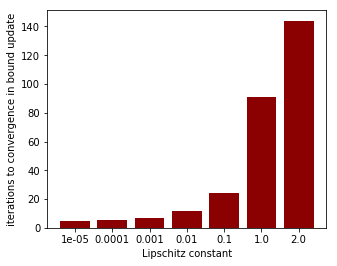


  KMEANS

    Lipschitz = 1e-05
    convergence_iter     M = 4.70     SD = 1.19
    optimum              M = 13366.62     SD = 596.44
    time                 M = 0.47     SD = 0.07

    Lipschitz = 0.0001
    convergence_iter     M = 5.70     SD = 1.27
    optimum              M = 13366.66     SD = 596.47
    time                 M = 0.55     SD = 0.08

    Lipschitz = 0.001
    convergence_iter     M = 7.40     SD = 0.49
    optimum              M = 13366.77     SD = 596.47
    time                 M = 0.65     SD = 0.03

    Lipschitz = 0.01
    convergence_iter     M = 12.40     SD = 0.49
    optimum              M = 13366.98     SD = 596.46
    time                 M = 0.83     SD = 0.04

    Lipschitz = 0.1
    convergence_iter     M = 25.70     SD = 1.00
    optimum              M = 13367.89     SD = 596.48
    time                 M = 1.48     SD = 0.07

    Lipschitz = 1.0
    convergence_iter     M = 98.30     SD = 4.88
    optimum              M = 13372.94     SD = 596.60
 

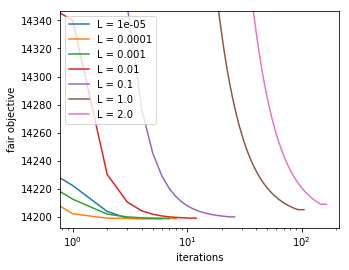

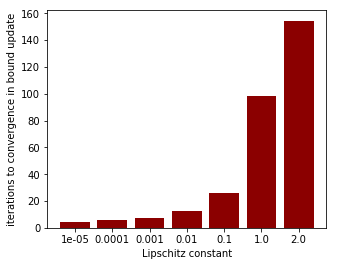


  NCUT

    Lipschitz = 1e-05
    convergence_iter     M = 1031.10     SD = 2990.00
    optimum              M = -976588187981902208.00     SD = 1491763096400013568.00
    time                 M = 53.30     SD = 153.52

    Lipschitz = 0.0001
    convergence_iter     M = 94.80     SD = 44.96
    optimum              M = -4281346.52     SD = 12844014.91
    time                 M = 4.95     SD = 2.19

    Lipschitz = 0.001
    convergence_iter     M = 188.80     SD = 3.84
    optimum              M = -9.24     SD = 0.03
    time                 M = 9.28     SD = 0.19

    Lipschitz = 0.01
    convergence_iter     M = 451.10     SD = 10.49
    optimum              M = -9.24     SD = 0.03
    time                 M = 20.99     SD = 0.46

    Lipschitz = 0.1
    convergence_iter     M = 2582.60     SD = 28.31
    optimum              M = -9.19     SD = 0.03
    time                 M = 130.03     SD = 1.01

    Lipschitz = 1.0
    convergence_iter     M = 10000.00     SD = 0.00
    optimu

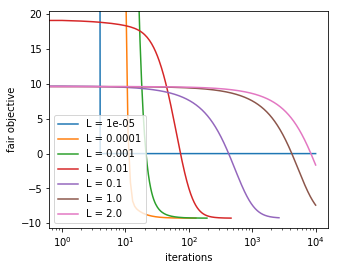

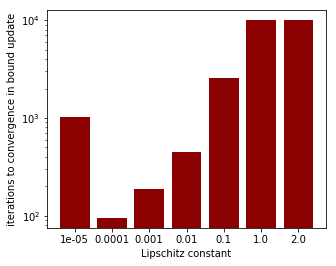

In [15]:
"""Fetch Lipschitz results from the csv and make plots"""
use_datasets = ["Adult", "Bank"]
for dataset in use_datasets:
    if dataset == "CensusII":
        continue
    print("\n\n"+dataset)
    for cluster_option in settings[dataset]:
        print("\n  "+cluster_option.upper())
        energy_list_by_L = {}
        conv_iter_by_L = {}
        complete = True
        for L in Lipschitz_constants:
            args = get_args(dataset=dataset, cluster_option=cluster_option, Lipschitz=L)
            existing_entries = find_same_options(CSV_NAME_LIPSCHITZ, args, keys=["dataset", "cluster_option", "L"])
            
            if len(existing_entries) < 1:
                print(f"no data yet on {dataset} with {cluster_option} at Lipshitz={L}")
                complete = False
                continue

            keys = ["convergence_iter", "optimum", "time"]
            # filtered_entries = filter_outliers(existing_entries, keys)
            # print(f"\n    Lipschitz = {L}       (excluded {len(existing_entries)-len(filtered_entries)} outliers)")
            # existing_entries = filtered_entries

            print(f"\n    Lipschitz = {L}")
            for key in keys:
                data = [float(entry[key]) for entry in existing_entries]
                mean = np.mean(data)
                std = np.std(data)

                if key == "convergence_iter":
                    conv_iter_by_L[L] = {
                        "mean": mean,
                        "std": std,
                    }

                print(f"    {key}{' '*(20-len(key))} M = {mean:.2f}     SD = {std:.2f}")

            energy_lists_by_run = []
            for entry in existing_entries:
                with open(os.path.join(args.output_path, entry["energy_list_file"]), "r") as f:
                    energy_lists_by_run.append(json.loads(f.read()))

            max_len = max([int(entry["convergence_iter"]) for entry in existing_entries])
            energy_array_by_run = np.zeros((len(existing_entries), max_len))
            for i, energy_list in enumerate(energy_lists_by_run):
                last_value = energy_list[-1]
                for iter in range(len(energy_list), max_len):
                    energy_list.append(last_value)
                energy_array_by_run[i] = energy_list
                # print(min(energy_list))
                
            energy_list_by_L[L] = {
                # "mean": np.mean(energy_array_by_run, axis=1),
                "mean": energy_array_by_run[0],
                "std": np.std(energy_array_by_run, axis=1),
            }

        if complete:
            save_dir = os.path.join(args.output_path, dataset)
            save_path = os.path.join(save_dir, f"{cluster_option}_"+"Lipschitz_plot{suffix}.png")
            plot_Lipschitz_convergence(save_path, energy_list_by_L)
            # plot_Lipschitz_convergence(save_path, energy_list_by_L, yscale_log=True)

            save_path = os.path.join(save_dir, f"{cluster_option}_"+"conv-iter_Lipschitz_plot{suffix}.png")
            plot_Lipschitz_conv_iter(save_path, conv_iter_by_L)